In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Create a mask with catalogue image using Gaussian smoothing + Otsu Thresholding

(-0.5, 515.5, 515.5, -0.5)

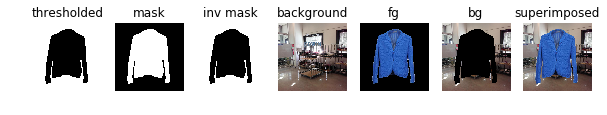

In [22]:
InteractiveShell.ast_node_interactivity = "last"

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

foreground_path = '../data/example_catalogue_image.jpg'
background_path = '../data/example_background_image.jpg'

foreground = cv2.imread(foreground_path)
background = cv2.imread(background_path)

###
# OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. 
# When you display an image loaded with OpenCv in matplotlib the channels will be back to front.
# The easiest way of fixing this is to use OpenCV to explicitly convert it back to RGB
###

foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]))

gray = cv2.cvtColor(foreground,cv2.COLOR_BGR2GRAY)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(gray,(5,5),0)
ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # a height x width, 2D

# positive mask
mask_bool = thresh == 255
mask_bool = np.dstack((mask_bool, mask_bool, mask_bool))

# negative mask
mask_bool_inv = np.invert(mask_bool)

plt.figure(figsize=(10,10))
# invert thresh for visualisation only
plt.subplot(1,7,1)
plt.imshow((np.invert(thresh)).astype('uint8')*255, cmap='binary')
plt.title('thresholded')
plt.axis('off')

# invert mask_bool for visualisation only
plt.subplot(1,7,2)
plt.imshow((np.invert(mask_bool)).astype('uint8')*255, cmap='binary')
plt.title('mask')
plt.axis('off')

# invert mask_bool_inv for visualisation only
plt.subplot(1,7,3)
plt.imshow((np.invert(mask_bool_inv)).astype('uint8')*255, cmap='binary')
plt.title('inv mask')
plt.axis('off')

plt.subplot(1,7,4)
plt.imshow(background)
plt.title('background')
plt.axis('off')

fg = foreground * mask_bool_inv
plt.subplot(1,7,5)
plt.imshow(fg)
plt.title('fg')
plt.axis('off')

bg = background * mask_bool
plt.subplot(1,7,6)
plt.imshow(bg)
plt.title('bg')
plt.axis('off')

superimposed = fg + bg
plt.subplot(1,7,7)
plt.imshow(superimposed)
plt.title('superimposed')
plt.axis('off')

## All code in one cell

In [25]:
def naive_mask(mask):
    ''' 
    Take an image of relatively homogenous background and turn into a mask.
    return a boolean mask and a boolean inversed mask
    '''
    import numpy as np
    
    r = mask[:,:,0]
    g = mask[:,:,1]
    b = mask[:,:,2]

    mask_bool = np.empty(mask.shape, dtype=bool)
    mask_bool_inv = np.empty(mask.shape, dtype=bool)

    mask_bool[:,:,0] = r==255 # True
    mask_bool[:,:,1] = g==255 # True
    mask_bool[:,:,2] = b==255 # True

    mask_bool_inv = np.invert(mask_bool)
            
    return mask_bool, mask_bool_inv

def otsu_mask(mask):
    ''' 
    Take an image of relatively homogenous background and turn into a mask using Otsu's Thresholding.
    return a boolean mask and a boolean inversed mask
    '''
    import numpy as np
    import cv2

    gray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(gray,(5,5),0)
    ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # a height x width, 2D

    # positive mask
    mask_bool = thresh == 255 
    mask_bool = np.dstack((mask_bool, mask_bool, mask_bool))

    # negative mask
    mask_bool_inv = np.invert(mask_bool)    
    
    return mask_bool, mask_bool_inv

def superimpose_images(foreground_path, background_path, mode):
    import numpy as np
    import cv2

    foreground = cv2.imread(foreground_path)
    background = cv2.imread(background_path)
    background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]))
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
    
    # use foreground as mask, in this case catalogue
    mask = foreground

    if mode == 'naive':
        mask_bool, mask_bool_inv = naive_mask(mask); 
    elif mode == 'otsu':
        mask_bool, mask_bool_inv = otsu_mask(mask); 
    
    # get the foreground, in this case is the object of interest in catalogue
    fg = foreground * mask_bool_inv
    # get the background, in this case is a background image
    bg = background * mask_bool
    # add 
    superimposed = fg + bg
    
    return superimposed

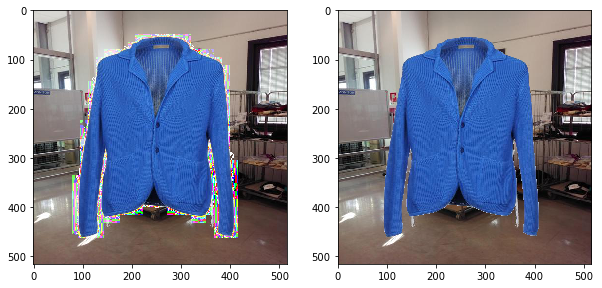

In [26]:
foreground_path = '../data/example_catalogue_image.jpg'
background_path = '../data/example_background_image.jpg'

plt.figure(figsize=(10,10))
superimposed = superimpose_images(foreground_path, background_path, mode='naive')
plt.subplot(1,2,1)
plt.imshow(superimposed)

superimposed = superimpose_images(foreground_path, background_path, mode='otsu')
plt.subplot(1,2,2)
plt.imshow(superimposed)